# Approche ligne à retard

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, linalg, integrate
from scipy.io.wavfile import write
import IPython

%matplotlib inline

## Modélisation excitateur

### Expression du débit ??

In [2]:
u_A = 200
delta_p_list = np.linspace(-20e3, 150e3, 1000)
p_M = 75e3

def u(u_A, delta_p, p_M):
    if delta_p > p_M:
        return 0
    else:
        return u_A * (1 - delta_p/p_M) * np.sqrt(np.abs(delta_p)/p_M) * np.sign(delta_p)

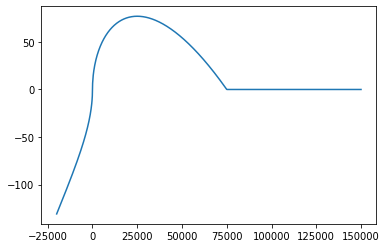

In [3]:
u_dp = np.zeros_like(delta_p_list)
for i, dp in enumerate(delta_p_list):
    u_dp[i] = u(u_A, dp, p_M)
plt.plot(delta_p_list, u_dp)
plt.show()

### Adimensionnement

In [4]:
def F(p, gamma, zeta):
    if (gamma - p) >= 1:
        return 0
    else:
        return zeta*(1-gamma+p)*np.sqrt(np.abs(gamma-p))*np.sign(gamma-p)

p_list = np.linspace(-1.5, 1.5, 1000)
gamma =  0.62
zeta = 0.6


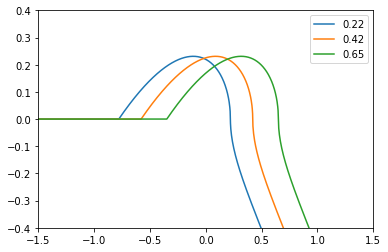

In [5]:
for gamma in [0.22, 0.42, 0.65]:

    u_p_list = np.zeros_like(p_list)
    for i, p in enumerate(p_list):
        u_p_list[i] = F(p, gamma, zeta)
    plt.plot(p_list, u_p_list, label=gamma)
    
plt.xlim([-1.5, 1.5])
plt.ylim([-0.4, 0.4])
plt.legend()
plt.show()

### Rotation F(p)

In [6]:
def G_plot(p, gamma, zeta):
    F_p = F(p, gamma, zeta)
    cos45 = np.sqrt(2)/2
    sin45 = np.sqrt(2)/2
    return cos45*F_p - sin45*p, sin45*F_p + cos45*p

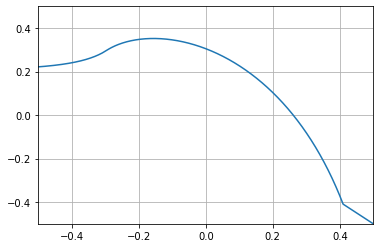

In [7]:
p_list = np.linspace(-1.5, 1.5, 10000)

for gamma in [0.42]:
    p_plus_list = np.zeros_like(p_list)
    p_minus_list = np.zeros_like(p_list)
    for i, p in enumerate(p_list):
        p_minus_list[i], p_plus_list[i] = G_plot(p, gamma, zeta)
    plt.plot(p_minus_list, p_plus_list, label=gamma)

plt.ylim(-0.5, 0.5)
plt.xlim(-0.5, 0.5)
plt.grid()
plt.show()


In [8]:
def G(p_n_1, gamma, zeta):    
    index_nearest_p_minus = (np.abs(p_minus_list - p_n_1)).argmin()
    p_plus_next = p_plus_list[index_nearest_p_minus]
    
    return p_plus_next

Gamma =  0.45
Zeta =  0.6


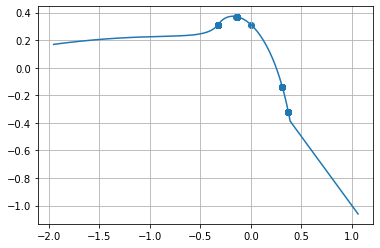

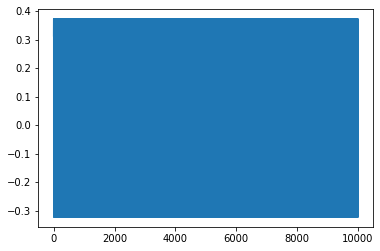

In [89]:
gamma = 0.45
zeta = 0.6

# === Calcul courbe (p_plus, p_moins) ===
p_list = np.linspace(-1.5, 1.5, 10000)
p_plus_list = np.zeros_like(p_list)
p_minus_list = np.zeros_like(p_list)
for i, p in enumerate(p_list):
    p_minus_list[i], p_plus_list[i] = G_plot(p, gamma, zeta)

    

# === Construction de la suite p_n ===
p_n = 0
N = 10000

points_p_minus = np.zeros(N)
points_p_plus = np.zeros(N)

for n in range(N):
    points_p_minus[n] = p_n
    p_n = G(p_n, gamma, zeta)
    points_p_plus[n] = p_n

# === Plot ===
print("Gamma = ", gamma)
print("Zeta = ", zeta)
    
plt.figure()
plt.plot(p_minus_list, p_plus_list)
plt.scatter(points_p_minus, points_p_plus)
plt.grid()

plt.figure()
plt.plot(points_p_plus)
plt.show()

#### Définition fonction de réflexion

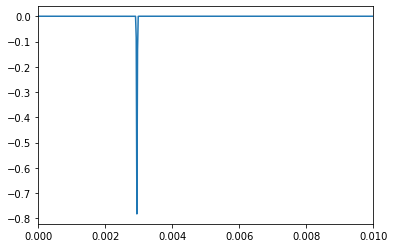

In [90]:
L = 0.5
c = 340

def r(t):
    mu = 2*L/c
    sig = 1e-5
    non_normalized = np.exp(-np.power(t - mu, 2.) / (2 * np.power(sig, 2.)))
    return -non_normalized / np.sum(non_normalized)

t_list = np.linspace(0, 1, 50000)
r_list = r(t_list)
plt.plot(t_list, r_list)
plt.xlim([0, 0.01])
plt.show()

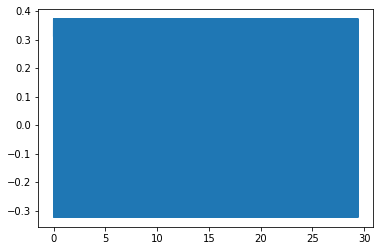

In [91]:
t_list_plus = np.linspace(0, N*2*L/c, N)
plt.figure()
plt.plot(t_list_plus, points_p_plus)
# plt.plot(points_p_plus)
# plt.xlim([2500, 2520])

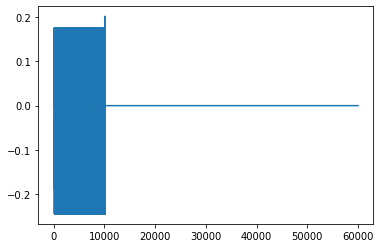

In [92]:
qi = np.convolve(r_list, points_p_plus)
plt.plot(qi)
# plt.ylim([-0.146, -0.144])
# plt.xlim([2500, 2520])

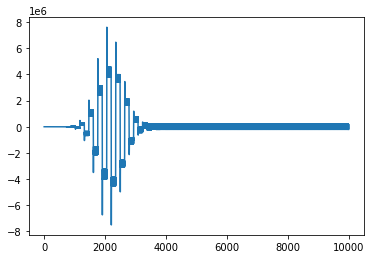

In [93]:
p_final = points_p_plus
next_qi = qi[:N]
for i in range(30): # On prend en compte 30 réflexions
    p_final = p_final + next_qi[:N]
    next_qi = np.convolve(r_list, p_final)
plt.plot(p_final)

### Output sound

In [94]:
def plot_sound(data, times,xlim1,xlim2,name='default_name',w=20,h=10, lw = 3):
    """
    Plot the waveform
    """
    len_x = len(data)
    plt.figure(figsize=(w, h))
    plt.plot(times,data.reshape(len_x))
    plt.xlim(xlim1,xlim2)
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    plt.title(name)
    plt.show()

    
def output_sound(X, end=1, name='test'):
    """
    Synthèse sonore du modele 3 modes 
    """
    Fs = 44100
    amplitude = 6000
    signal_synth = X/np.max(X)*amplitude
    len_sig = len(signal_synth)
    signal_synth = signal_synth.reshape(len_sig)

    timestep = 1/(float(Fs))
    times_new = np.arange(len_sig)*timestep
    plot_sound(signal_synth, times_new, 0, end, name='Transitoire', w=10, h=7)

    filename = f'{name}.wav'
    write(filename, Fs, np.array(signal_synth, dtype=np.int16)) # to write a new wave file

    return len_sig, signal_synth

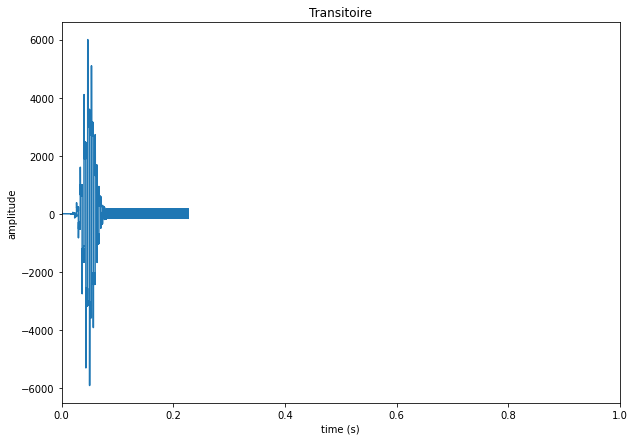

delay_line


In [95]:
filename = "delay_line"
output_sound(p_final, name=filename)


print(filename)
IPython.display.Audio(filename+".wav")